In [1]:
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.calibration import CalibratedClassifierCV as CCCV
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score as ppv
from sklearn.metrics import recall_score as recall
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.multioutput import ClassifierChain
from xgboost import XGBClassifier as xgb
import itertools
import ipywidgets as widgets
import joblib
import numpy as np
import pandas as pd
import pip
import shap
InteractiveShell.ast_node_interactivity = "all"

In [4]:
Xi=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\Xi.csv')
Xi_hold=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\Xi_hold.csv')
y=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y.csv')
y_hold=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold.csv')
y_hold_nssi=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_nssi.csv')
y_hold_si=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_si.csv')

In [5]:
#Dropping the sitbs column as we are only interested in predicting each component outcome with the chained classifier
y=y.drop(columns='sitbs')

In [5]:
RF=RandomForestClassifier(n_estimators=250, min_samples_split=50, max_features=200, random_state=26)
baseclf=CCCV(RF, method='isotonic')
chain=ClassifierChain(baseclf, order=None, random_state=26)

In [6]:
chain.fit(Xi, y)

ClassifierChain(base_estimator=CalibratedClassifierCV(estimator=RandomForestClassifier(max_features=200,
                                                                                       min_samples_split=50,
                                                                                       n_estimators=250,
                                                                                       random_state=26),
                                                      method='isotonic'),
                random_state=26)

In [32]:
#Creating function that predicts probabilities using the calibrated model
def predict(model, data):
    proba=model.predict_proba(data)
    print('Probs: %.3f (%.3f)' % (mean(proba), std(proba)) )

    return proba

In [9]:
testprob=predict(chain, Xi_hold)

Probs: 0.080 (0.137)


In [10]:
testprob

array([[0.08751433, 0.0193342 , 0.01164665],
       [0.32529954, 0.0193342 , 0.01029261],
       [0.01494564, 0.00528675, 0.00404546],
       ...,
       [0.02295547, 0.01525256, 0.00621937],
       [0.10473921, 0.02001447, 0.01029261],
       [0.07783935, 0.02881188, 0.01029261]])

In [11]:
nssi=testprob[:, 1]
nssip=np.where(nssi>0.160344, 1, 0)

In [12]:
def eval(y_hold, ypred, yprob):
    f1= f1_score(y_hold, ypred)
    print(f'F1= {f1:f}')
    sens= recall(y_hold, ypred)
    print(f'Sensitivity= {sens:f}')
    tn, fp, fn, tp= confusion(y_hold, ypred).ravel()
    spec=tn/(tn+fp)
    print(f'Specificity= {spec:f}')
    auc= roc_auc_score(y_hold, yprob)
    print(f'AUROC= {auc:f}')

    return ypred, f1, sens, spec, auc


In [13]:
si=testprob[:, 0]
sip=np.where(si>0.175579, 1, 0)

In [14]:
eval(y_hold_si, sip, si)

F1= 0.456140
Sensitivity= 0.677083
Specificity= 0.804107
AUROC= 0.815643


(array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 

In [15]:
eval(y_hold_nssi, nssip, nssi)

F1= 0.400000
Sensitivity= 0.410714
Specificity= 0.946508
AUROC= 0.806357


(array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [16]:
joblib.dump(chain, 'cclf2802_RF.sav')

['cclf2802_RF.sav']

In [17]:
att=testprob[:, 2]
attp=np.where(att>0.073374, 1, 0)

In [18]:
y_hold_att=y_hold['att']

In [19]:
eval(y_hold_att, attp, att)

F1= 0.325000
Sensitivity= 0.406250
Specificity= 0.949785
AUROC= 0.797391


(array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [22]:
sre = ['si', 'nssi', 'att']
# Saving the base estimators in the chain
for idx, s in enumerate(sre):
    globals()[f"{s}_est"] = chain.estimators_[idx]

Getting Shapley Values

In [7]:
#Loading the previously fitted classifier chain
chain=joblib.load(r'c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\models\cclf2802_RF.sav')
  

In [8]:
explainer=shap.KernelExplainer(model=chain.predict_proba, data=Xi.head(200))

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values=explainer.shap_values(X=Xi_hold.head(200), nsamples=2022)

  0%|          | 0/200 [00:00<?, ?it/s]

SI Beeswarm Plot


([<matplotlib.axis.YTick at 0x246739b5120>,
 [Text(0, 0, 'smfq'),
  Text(0, 1, 'se16b2'),
  Text(0, 2, 'pssm'),
  Text(0, 3, 'csdqtb'),
  Text(0, 4, 'hs54b'),
  Text(0, 5, 'cemot'),
  Text(0, 6, 'chu9d'),
  Text(0, 7, 'hs54c'),
  Text(0, 8, 'hs54a'),
  Text(0, 9, 'hs54d')])

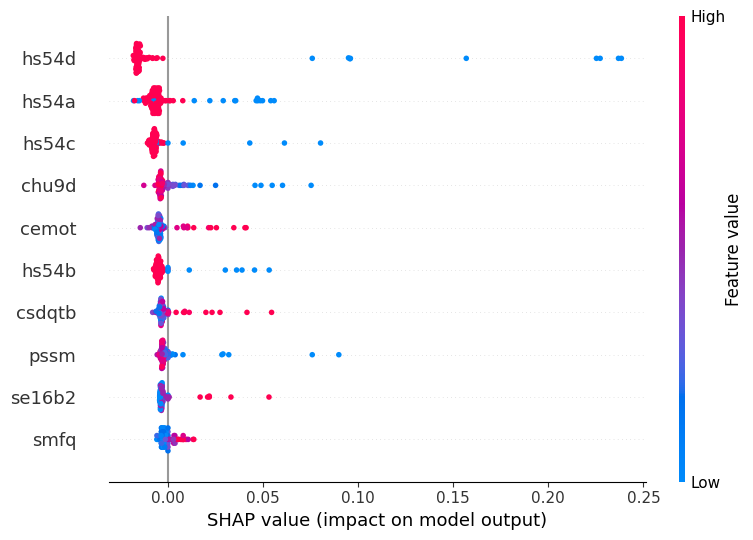

In [108]:
#Note that shap.initjs() needs to be run to produce the visualisations- otherwise there will be an error that says Javascript library not omitted
shap.initjs()
print('SI Beeswarm Plot')
#Note- to customise the bar plot further, specify show=False to avoid calling matplotlib.pyplot.show() before the extra customisation code occurs
shap.summary_plot(shap_values[0], features=Xi_hold.head(100), max_display=10, show=False)
si_flabels=['Prior suicide plan', 'Prior self-harm thoughts', 'CHU9D score', 'Prior suicidal ideation', 'SDQ emotional symptoms', 'Prior self-harm', 'SDQ total score', 'Felt afraid', 'PSSM scale', 'Worries']
si_flabels.reverse()
#Insert labels=si_flabels below when available
plt.yticks(range(10))
plt.show()

#Self-harm related questions are coded as 1 Yes 2 No

NSSI Beeswarm Plot


([<matplotlib.axis.YTick at 0x2467417b460>,
 [Text(0, 0, 'hs44p42'),
  Text(0, 1, 'smfq'),
  Text(0, 2, 'chu9d'),
  Text(0, 3, 'hs48a7'),
  Text(0, 4, 'pssm'),
  Text(0, 5, 'apgsi'),
  Text(0, 6, 'hs54a'),
  Text(0, 7, 'hs54c'),
  Text(0, 8, 'hs54d'),
  Text(0, 9, 'hs54b')])

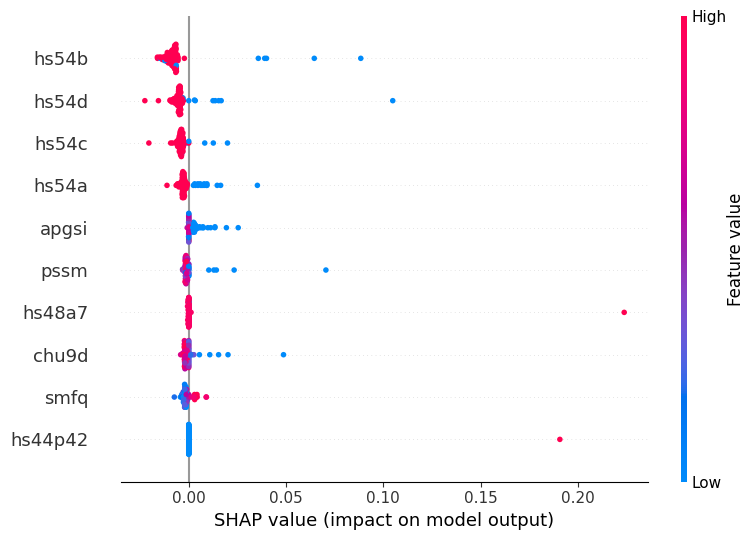

In [107]:
print('NSSI Beeswarm Plot')
#Note- to customise the bar plot further, specify show=False so that matplotlib.pyplot.show() is not called before the extra customisation code occurs
shap.summary_plot(shap_values[1], features=Xi_hold.head(100), max_display=10, show=False)
plt.yticks(range(10))
plt.show()


Attempts Beeswarm Plot


([<matplotlib.axis.YTick at 0x24673a3c310>,
 [Text(0, 0, 'pssm'),
  Text(0, 1, 'aconsc'),
  Text(0, 2, 'se16b2'),
  Text(0, 3, 'cresl'),
  Text(0, 4, 'cemot'),
  Text(0, 5, 'chu9d'),
  Text(0, 6, 'hs54b'),
  Text(0, 7, 'csdqtb'),
  Text(0, 8, 'hs54c'),
  Text(0, 9, 'hs54d')])

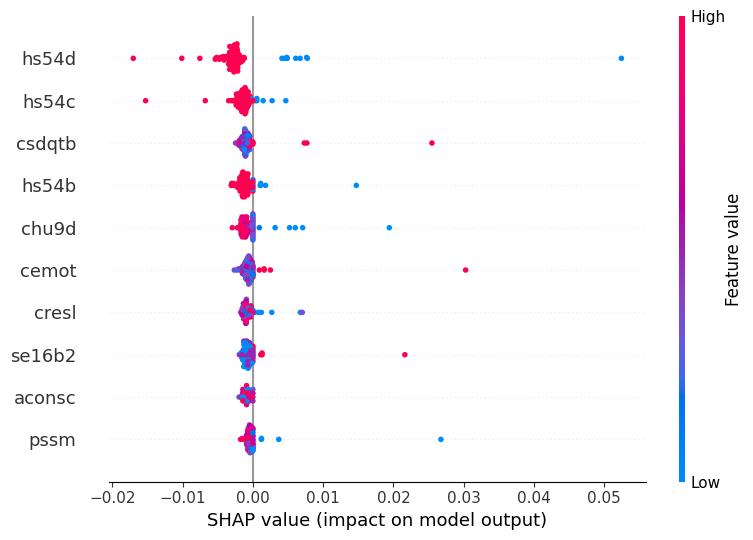

In [111]:
print('Attempts Beeswarm Plot')
#Note- to customise the bar plot further, specify show=False so that matplotlib.pyplot.show() is not called before the extra customisation code occurs
shap.summary_plot(shap_values[2], features=Xi_hold.head(100), max_display=10, show=False)
plt.yticks(range(10))
plt.show()

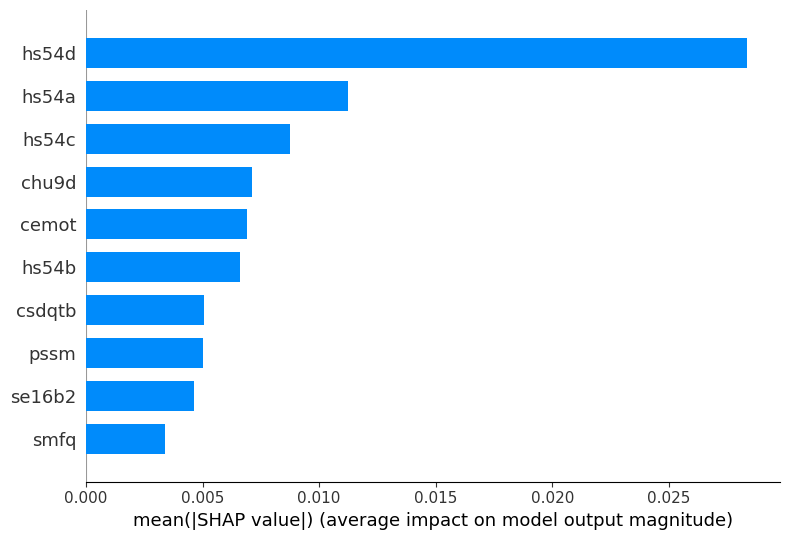

In [112]:
shap.summary_plot(shap_values[0], features=Xi_hold.head(100), plot_type='bar', max_display=10)

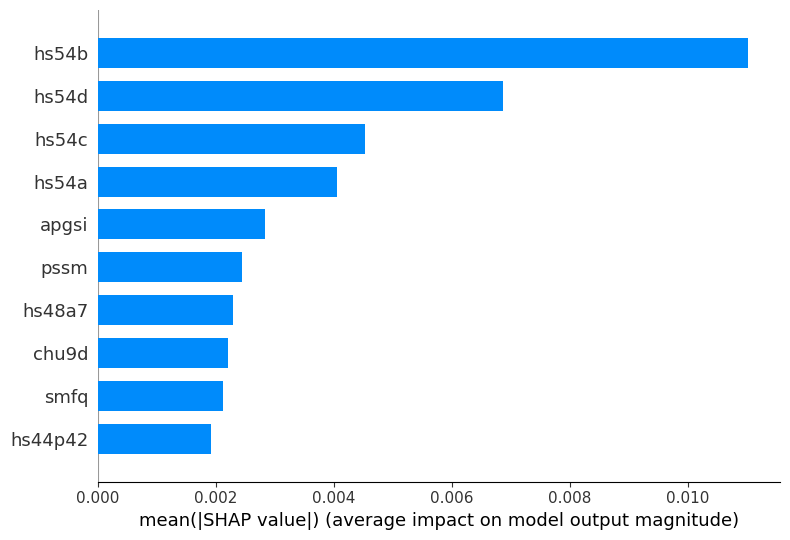

In [113]:
shap.summary_plot(shap_values[1], features=Xi_hold.head(100), plot_type='bar', max_display=10)

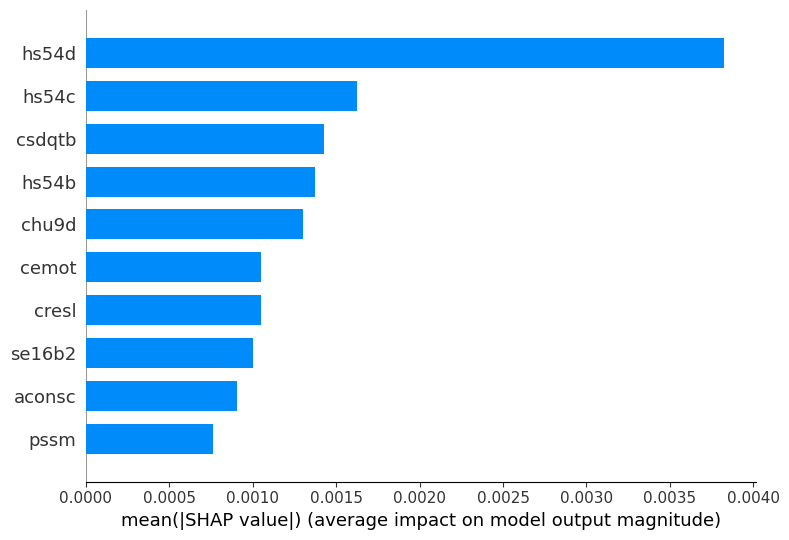

In [114]:
shap.summary_plot(shap_values[2], features=Xi_hold.head(100), plot_type='bar', max_display=10)